*Last Edited: 07/26/2022*

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

os.chdir('/content/drive/MyDrive/MeetfreshCV Group 3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 1: Prepare Data
#### (a) split data

In [5]:
import shutil
!pip install split-folders
import splitfolders

# IN_DIR = 'data/data_aug'; ratio = (0.7, 0.2, 0.1)
IN_DIR = 'outputs/2.2_classifier'; ratio = (0.7, 0.2, 0.1)  ## ratio = (0.2, 0.4, 0.4)
OUT_DIR = 'data/yolo prediction'

## empty out_dir if exist
if os.path.exists(os.path.join(OUT_DIR)):
  shutil.rmtree(OUT_DIR)

## split train, valid, test
splitfolders.ratio(IN_DIR, output = OUT_DIR, seed = 2022, ratio = ratio) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 700 files [00:29, 32.78 files/s]

KeyboardInterrupt: ignored

#### (b) load by generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 100
IMG_SIZE = 100
IMG_DIR = 'data/data_model'

train = ImageDataGenerator(rescale = 1./255)
train_dataset = train.flow_from_directory(
    directory = IMG_DIR + '/train',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True)

valid = ImageDataGenerator(rescale = 1./255)
valid_dataset = valid.flow_from_directory(
    directory = IMG_DIR + '/val',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False)

test = ImageDataGenerator(rescale = 1./255)
test_dataset = test.flow_from_directory(
    directory = IMG_DIR + '/test',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False)

Found 2202 images belonging to 14 classes.
Found 624 images belonging to 14 classes.
Found 327 images belonging to 14 classes.


### Step 2: Modeling
#### (a) define model structure

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

from keras.applications.xception import Xception

## set up base model
base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

## complete architecture
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', use_bias = True))
model.add(Dense(14, activation = 'sigmoid'))

## freeze base weights
base_model.trainable = False 

## compile 
LR_RT = 1e-4
model.compile(
    optimizer = RMSprop(learning_rate = LR_RT),
    loss = 'categorical_crossentropy',   
    metrics = ['accuracy']) 

83697664/83683744 [==============================] - 1s 0us/step


#### (b) add callbacks

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

MODEL_DIR = 'outputs'

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3, 
    min_lr = 1e-7)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(MODEL_DIR, '2_models/2_model_{epoch:02d}.h5'),
    monitor = 'val_acc',
    save_best_only = False,
    save_weights_only = False)

#### (c) begin training

In [ ]:
EPOCHS = 20

start = time.time()
model.fit(
    train_dataset, 
    steps_per_epoch = train_dataset.n // BATCH_SIZE, 
    epochs = EPOCHS, 
    validation_data = valid_dataset,
    validation_steps = valid_dataset.n // BATCH_SIZE,
    callbacks = [reduce_lr, checkpoint]
)
end = time.time()
print(f'Running Time: {(end - start)/3600} hrs.')

Epoch 1/20
22/22 [==============================] - 391s 17s/step - loss: 1.0980 - accuracy: 0.6613 - val_loss: 0.5700 - val_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 2/20
22/22 [==============================] - 351s 16s/step - loss: 0.4505 - accuracy: 0.8725 - val_loss: 0.3520 - val_accuracy: 0.9183 - lr: 1.0000e-04
Epoch 3/20
22/22 [==============================] - 352s 16s/step - loss: 0.2771 - accuracy: 0.9253 - val_loss: 0.2877 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 4/20
22/22 [==============================] - 345s 16s/step - loss: 0.2034 - accuracy: 0.9496 - val_loss: 0.2316 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 5/20
22/22 [==============================] - 345s 16s/step - loss: 0.1214 - accuracy: 0.9743 - val_loss: 0.2236 - val_accuracy: 0.9450 - lr: 1.0000e-04
Epoch 6/20
22/22 [==============================] - 344s 16s/step - loss: 0.0924 - accuracy: 0.9819 - val_loss: 0.2950 - val_accuracy: 0.9133 - lr: 1.0000e-04
Epoch 7/20
22/22 [============================

Running Time: 2.0422020655208164 hrs.


#### (d) plot scores

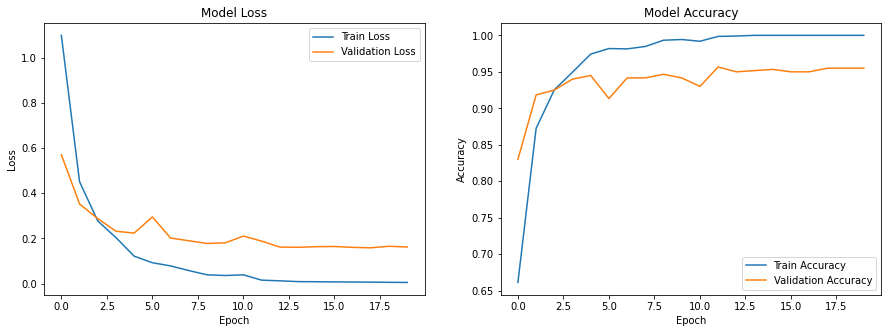

In [ ]:
import matplotlib.pyplot as plt

history = model.history
fig, ax = plt.subplots(1, 2, figsize = (15,5))
_= ax[0].set_title('Model Loss')
_= ax[0].plot(history.epoch, history.history['loss'], label = 'Train Loss')
_= ax[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
_= ax[0].set_ylabel('Loss')
_= ax[0].set_xlabel('Epoch')
_= ax[0].legend()

_= ax[1].set_title('Model Accuracy')
_= ax[1].plot(history.epoch, history.history['accuracy'], label = 'Train Accuracy')
_= ax[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
_= ax[1].set_ylabel('Accuracy')
_= ax[1].set_xlabel('Epoch')
_= ax[1].legend()
plt.show()